# Importing libraries

In [1]:
from diff_weighted_fields import Grid1D, GaussianFieldGenerator1D, Zeldovich1D, PowerSpectrum, MCMC
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.random import PRNGKey, split
import jax
from tqdm import tqdm
from mycolorpy import colorlist as mcp
from diff_weighted_fields.utils import covariance_to_correlation_batch, covariance_to_correlation, make_flatten_C
import numpy as np
plt.style.use('thesis.mplstyle')

#grid setup
L = 4000
N = 1024
dk     = 6  #units of kf 
kmin   = 4  #units of kf
R_smooth = 3  #units of cell size
kmax   = 0.5 #units of kNyq

def PK(k,theta, threshold = 0.001):
    A,R,n = theta
    physical_R = R * mesh.H[0]
    k_std = jnp.pi/physical_R
    _p = A*(k*R)**n*jnp.exp(-0.5*(k/k_std)**2)
    sig = jnp.max(_p)
    return _p + sig* threshold

#define the field and gaussian generator
grid = Grid1D((N,), L, R_clip = R_smooth)
mesh = Grid1D((N//2,), L, dk =dk, kmax = kmax , kmin =kmin, R_gauss = R_smooth*0.5)
gen = GaussianFieldGenerator1D(grid, PK)
zel = Zeldovich1D(gen, mesh, scheme = 'tsc')

print(mesh)
print('Pk has:', len(mesh.k_ctrs), 'bins')

#Hyperparameters
A = 2.0
R_pk = 18. #units of cell size
n = 3.
R_mark = 0. #units of cell size
theta = jnp.array([A, R_pk, n])
Nmocks = 700
D_star = 3.0
C0_1T = jnp.array([[1.,0.,0.,0.]])
C0_2T = jnp.array([[[1.,0.,0.,0.] ,[1., 0., 0., 0.]]])
SHRINKAGE = 0.0005
#SHRINKAGE = 0.

Using clipping smoothing with R_clip = 3 cells (physical = 11.71875); k_smooth = 2.681e-01
Using smoothing smoothing with R_gauss = 1.5 cells (physical = 11.71875); k_smooth = 2.681e-01
Using Gaussian smoothing with R_gauss = 1.5
kmin: 0.006283185307179587
kmax: 0.20106192982974677
dk: 0.00942477796076938
N: 512
Shape: (512,)
L: 4000
Volume: 4000.0

Pk has: 21 bins


In [2]:
#white noise used to generate the field
keys = split(PRNGKey(3),Nmocks)
noise = jnp.array([grid.generate_hermitian_noise(x) for x in keys])
noise_mesh = jnp.array([mesh.generate_hermitian_noise(x) for x in keys])

def get_single_m(theta, D, R_mark, single_noise):
    zel = Zeldovich1D(gen, mesh, scheme='tsc')
    zel.make_realization(D, theta, single_noise)
    zel.ComputeBasis(R_mark)
    return zel.m_array

get_m = jax.jit(lambda theta, D, R_mark: jnp.concatenate(
    [jnp.array([1]), jnp.mean(
        jnp.std(jax.vmap(get_single_m, in_axes=(None, None, None, 0))(theta, D, R_mark, noise), axis=-1), axis=0
    )[1:]]
))
#m_norm_ref = get_m(theta, D_star, R_mark)

def compute_cov(x):
    x = x - jnp.mean(x, axis=0)
    return (x.T @ x) / (x.shape[0] - 1)
compute_cov_batch = jax.vmap(compute_cov, in_axes=0)

"""
def compute_inv_cov(x):
    x = x - jnp.mean(x, axis=0)
    cov = (x.T @ x) / (x.shape[0] - 1)
    p_eff = jax.numpy.linalg.matrix_rank(cov)
    hartlap = (Nmocks - p_eff - 2.0) / (Nmocks - 1.0)
    return jnp.linalg.inv(cov)*hartlap
compute_inv_cov_batch = jax.vmap(compute_inv_cov, in_axes=0)
"""

def compute_inv_cov(x, shrink=SHRINKAGE, eps=0):#1e-5):
    """
    Stabilized inverse covariance with correlation shrinkage and eigenvalue floor.
    Accepts any of:
      - (Nmocks, p)                   : samples for one data vector
      - (p, p)                        : one covariance matrix
      - (B, Nmocks, p)                : batched samples
      - (B, p, p)                     : batched covariance matrices

    Returns:
      - (p, p) for single input
      - (B, p, p) for batched input
    """
    def _from_samples(X):
        # X: (Nmocks, p)
        X = X - jnp.mean(X, axis=0)
        cov = (X.T @ X) / (X.shape[0] - 1)     # (p,p)
        p = cov.shape[0]
        std = jnp.sqrt(jnp.clip(jnp.diag(cov), 1e-20, None))
        Dinv = jnp.diag(1.0 / std)
        corr = Dinv @ cov @ Dinv
        corr = (1.0 - shrink) * corr + shrink * jnp.eye(p)
        corr_sym = (corr + corr.T) / 2
        w, V = jnp.linalg.eigh(corr_sym)
        w = jnp.clip(w, eps, None)
        inv_corr = (V / w) @ V.T
        inv_cov = Dinv @ inv_corr @ Dinv
        # Hartlap with effective rank (your original behavior)
        p_eff = jax.numpy.linalg.matrix_rank(cov)
        n = X.shape[0]
        hartlap = (n - p_eff - 2.0) / (n - 1.0)
        return inv_cov * hartlap

    def _from_cov(C):
        # C: (p,p)
        p = C.shape[0]
        # correlation from covariance
        std = jnp.sqrt(jnp.clip(jnp.diag(C), 1e-20, None))
        Dinv = jnp.diag(1.0 / std)
        corr = Dinv @ C @ Dinv
        corr = (1.0 - shrink) * corr + shrink * jnp.eye(p)
        corr_sym = (corr + corr.T) / 2
        w, V = jnp.linalg.eigh(corr_sym)
        w = jnp.clip(w, eps, None)
        inv_corr = (V / w) @ V.T
        inv_cov = Dinv @ inv_corr @ Dinv
        # No Hartlap here (no Nmocks info)
        return inv_cov

    # ---- dispatch on shape ----
    if x.ndim == 2:
        # Either (Nmocks,p) or (p,p) if square
        return jax.lax.cond(
            x.shape[0] == x.shape[1],
            _from_cov,      # treat as covariance
            _from_samples,  # treat as samples
            x
        )
    elif x.ndim == 3:
        # Either (B,Nmocks,p) or (B,p,p)
        is_cov = x.shape[1] == x.shape[2]
        if is_cov:
            return jax.vmap(_from_cov, in_axes=0)(x)
        else:
            return jax.vmap(_from_samples, in_axes=0)(x)
    else:
        raise ValueError(f"Unsupported input shape {x.shape} for compute_inv_cov")

# Keep this alias for backward compatibility; it now just calls the shape-aware version.
compute_inv_cov_batch = compute_inv_cov

def compute_pk_lin_single(theta,noise):
    gen = GaussianFieldGenerator1D(mesh, PK)
    f = gen.make_realization_from_noise(theta, noise)
    return PowerSpectrum(f,f)

compute_pk_lin_batch = lambda theta: jax.vmap(compute_pk_lin_single, in_axes=(None, 0))(theta, noise_mesh)
compute_pk_lin = lambda theta: jnp.mean(compute_pk_lin_batch(theta), axis=0)
jac_pk_lin = jax.jacfwd(compute_pk_lin, argnums=0)

def compute_F_lin(theta):
    """
    Computes the Fisher matrix for the linear power spectrum.
    """
    P = compute_pk_lin_batch(theta)
    inv_cov = compute_inv_cov(P)
    #inv_cov = compute_inv_cov_batch(P)
    J = jac_pk_lin(theta)
    F = jnp.einsum('ij, ip, jq->pq', inv_cov, J, J)
    return F

@jax.jit
def compute_pk_1T(theta,D,C,R_mark):
    m_norm = jax.lax.stop_gradient(get_m(theta, D, R_mark))
    pk_batch = zel.make_realization_batch(D,theta,R_mark,C/m_norm,noise)
    return pk_batch

@jax.jit
def compute_pk_2T(theta,D,C,R_mark):
    m_norm = jax.lax.stop_gradient(get_m(theta, D, R_mark))
    pk_batch = zel.make_realization_batch_2T(D, theta, R_mark, C/m_norm, noise)
    return pk_batch

@jax.jit
def compute_gauss_entropy_batch_ST(theta,D,C,R_mark):
    P = compute_pk_1T(theta, D, C, R_mark)
    cov = compute_cov_batch(P)
    corr = covariance_to_correlation_batch(cov)
    gauss_ent = 0.5*jnp.log(jnp.linalg.det(corr))
    return gauss_ent

@jax.jit
def compute_gauss_entropy_batch_MT(theta,D,C,R_mark):
    P = compute_pk_2T(theta, D, C, R_mark)
    cov = compute_cov_batch(P)
    corr = covariance_to_correlation_batch(cov)
    gauss_ent = 0.5*jnp.log(jnp.linalg.det(corr))
    return gauss_ent

@jax.jit
def compute_gauss_entropy_batch_MT_cross(theta, D, C, R_mark):
    P = compute_pk_2T(theta, D, C, R_mark)
    N = P.shape[-1] // 3
    cross = P[:, :, N:2 * N]
    cov = compute_cov_batch(cross)
    corr = covariance_to_correlation_batch(cov)
    gauss_ent = 0.5 * jnp.log(jnp.linalg.det(corr))
    return gauss_ent

jac_pk_MT = jax.jacfwd(compute_pk_2T, argnums=0)
def compute_F_batch_2T(theta,D,C,R_mark):
    P = compute_pk_2T(theta, D, C, R_mark)
    #inv_cov = compute_inv_cov_batch(P)
    inv_cov = compute_inv_cov_batch(P)   
    J = jac_pk_MT(theta, D, C, R_mark)
    J = jnp.mean(J, axis=1)
    F = jnp.einsum('nij, nip, njq->npq', inv_cov, J, J)
    return F

compute_F_D_batch_2T = jax.jit(jax.vmap(compute_F_batch_2T, in_axes=(None, 0, None, None)))
compute_F_batch_2T = jax.jit(compute_F_batch_2T)

jac_pk_ST = jax.jacfwd(compute_pk_1T, argnums=0)

@jax.jit
def compute_F_batch_1T(theta,D,C,R_mark):
    P = compute_pk_1T(theta, D, C, R_mark)
    #inv_cov = compute_inv_cov_batch(P)
    inv_cov = compute_inv_cov_batch(P)
    J = jac_pk_ST(theta, D, C, R_mark)
    J = jnp.mean(J, axis=1)
    F = jnp.einsum('nij, nip, njq->npq', inv_cov, J, J)
    return F

@jax.jit
def compute_D_sc(theta, noise_batch):
    def single_D_sc(noise_i):
        psi_q = zel.compute_displacement(theta, noise_i)
        dif_psi_q = jnp.diff(psi_q)
        min_dpsi = jnp.min(dif_psi_q)
        return -grid.H[0] / min_dpsi

    D_sc_batch = jax.vmap(single_D_sc)(noise_batch)
    return jnp.min(D_sc_batch), D_sc_batch

Maximum safe growth factor before shell-crossing: D = 4.9334


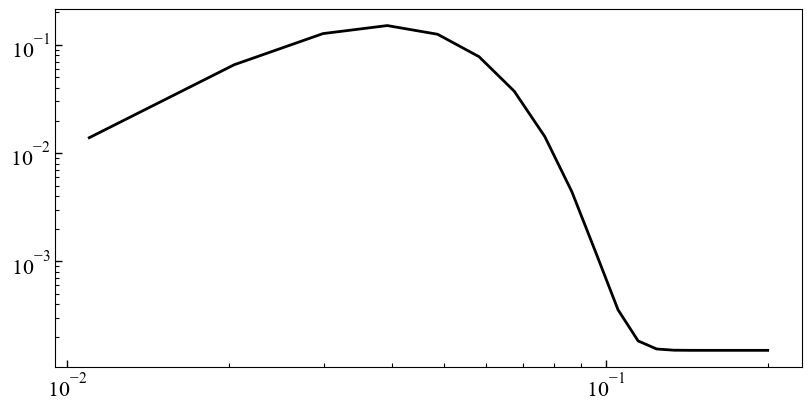

In [3]:
D_sc_safe, D_sc_all = compute_D_sc(theta, noise)
print(f"Maximum safe growth factor before shell-crossing: D = {D_sc_safe:.4f}")
plt.figure(figsize =(8,4), dpi = 100)
plt.loglog(mesh.k_ctrs,PK(mesh.k_ctrs, theta), label='Power Spectrum', color='black')

Gaussian Case

In [4]:
#F_LIN = compute_F_lin(theta)
#detF_LIN = jnp.linalg.det(F_LIN)

In [5]:
Fs = []
D_vec = jnp.logspace(-2.,jnp.log10(5.),25)
for d in D_vec:
    Fs.append(compute_F_batch_1T(theta, d, C0_1T, R_mark))
Fs = jnp.array(Fs)
detFs = jnp.linalg.det(Fs)

In [6]:
C_MT = jnp.array([[[1., 0., 0., 0.], [1., -0.3, 0.05, 0.]]])

In [7]:
x = jnp.linalg.det(compute_F_D_batch_2T(theta, D_vec, C_MT, R_mark).block_until_ready())

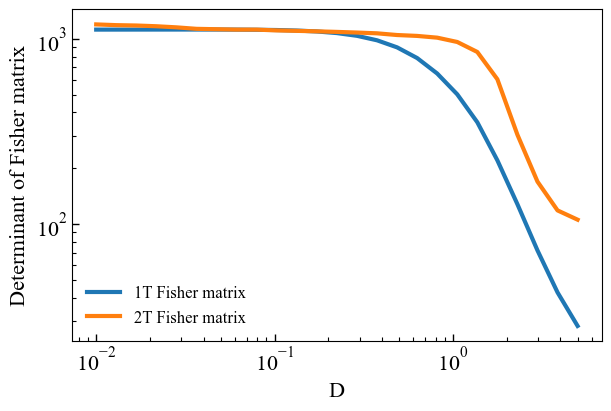

In [8]:
plt.figure(dpi = 100)
#plt.hlines(detF_LIN, D_vec[0], D_vec[-1], colors='k', linestyles='--', label='Fisher matrix for linear theory')
plt.loglog(D_vec,detFs, lw = 3, label = '1T Fisher matrix')
plt.loglog(D_vec,x, lw = 3, label = '2T Fisher matrix')
plt.xlabel('D')
plt.ylabel('Determinant of Fisher matrix')
plt.legend()

In [9]:
C0_2T = jnp.array([[[1,0,0,0],[1, 0.100, 0,0]]])
jnp.linalg.det(compute_F_batch_2T(theta, 0.01, C0_2T, R_mark))/jnp.linalg.det(compute_F_batch_1T(theta, 0.01, C0_1T, R_mark))

Array([0.95923239], dtype=float64)

# ST

In [10]:
def create_c_1T(Nx, Ny, c_vec_x_min, c_vec_x_max, c_vec_y_min, c_vec_y_max):
    # Generate c_vec for x and y
    c_vec_x = jnp.concatenate([
        -jnp.logspace(jnp.log10(c_vec_x_min), jnp.log10(c_vec_x_max), Nx // 2, endpoint=False)[::-1],
         jnp.array([0.0]),
         jnp.logspace(jnp.log10(c_vec_x_min), jnp.log10(c_vec_x_max), Nx // 2, endpoint=True)[:-1]
    ])
    c_vec_y = jnp.concatenate([
        -jnp.logspace(jnp.log10(c_vec_y_min), jnp.log10(c_vec_y_max), Ny // 2, endpoint=False)[::-1],
         jnp.array([0.0]),
         jnp.logspace(jnp.log10(c_vec_y_min), jnp.log10(c_vec_y_max), Ny // 2, endpoint=True)[:-1]
    ])

    # Create meshgrid
    C1, C2 = jnp.meshgrid(c_vec_x, c_vec_y, indexing='ij')
    C0 = jnp.ones_like(C1)
    C3 = jnp.zeros_like(C1)
    
    # Stack into (Nx, Ny, 4) and then flatten to (Nx*Ny, 4)
    C_plane = jnp.stack([C0, C1, C2, C3], axis=-1)
    C_flat = C_plane.reshape(-1, 4)
    return C1,C2,C_flat, c_vec_x, c_vec_y

In [11]:
D = 2.0
Nx, Ny = 50, 50
x_min,x_max = 1e-3, 0.2
y_min,y_max = 1e-3, 0.1
C1_ST,C2_ST,C_flat,c1_vec, c2_vec = create_c_1T(Nx, Ny, x_min, x_max, y_min, y_max)

## entropy

In [ ]:
batch_size = 10
steps = C_flat.shape[0] // batch_size 
_ = compute_gauss_entropy_batch_ST(theta, D, C_flat[0:batch_size], R_mark).block_until_ready()  
for i in tqdm(range(steps)):
    start = i * batch_size
    end = start + batch_size
    entropy_single = compute_gauss_entropy_batch_ST(theta, D, C_flat[start:end], R_mark).block_until_ready()
    if i == 0:
        entropy_all = entropy_single
    else:
        entropy_all = jnp.concatenate([entropy_all, entropy_single])

In [212]:
entropy_all = entropy_all.reshape(Nx, Ny)

In [213]:
entropy_all = entropy_all.reshape(Nx, Ny)
entropy_vanilla = compute_gauss_entropy_batch_ST(theta, D, jnp.array([[1,0,0,0]]), R_mark).block_until_ready()
best_point = C_flat[jnp.argmax(entropy_all)]
best_entropy = jnp.max(entropy_all)
i0 = jnp.argmin(jnp.abs(c1_vec))  
j0 = jnp.argmin(jnp.abs(c2_vec))

In [ ]:
fig, ax = plt.subplots(figsize=(6,5), dpi=200)

# Match the levels and colormap style
levels = np.linspace(-50, np.max(entropy_all), 50)
cf = ax.contourf(C1_ST, C2_ST, jnp.clip(entropy_all, a_min=-50, a_max=None),
                 levels=levels, cmap='PiYG', linewidths=1)

# Arrow from origin to max entropy point
x_ent, y_ent = best_point[1], best_point[2]
ax.annotate('', xy=(x_ent, y_ent), xytext=(0, 0),
            arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5))

# Scatter points
ax.scatter([0], [0], marker='o', color='black', s=5, zorder=10)
ax.scatter(x_ent, y_ent, marker='*', color='black', s=30, zorder=10)

# Annotate entropy at origin
origin_value = entropy_vanilla
ax.text(0, 0.005, f'{origin_value.item():.2f}', color='black', fontsize=10, ha='center', va='center')

# Annotate best entropy
best_entropy_val = best_entropy
ax.text(x_ent, y_ent - 0.005, f'{best_entropy_val.item():.2f}', color='black', fontsize=10, ha='center', va='center')

# Annotate D
ax.text(0.0,0.095, f'D = {D:.2f}', 
         color='black', fontsize=10, ha='center', va='center')

# Labels and limits
ax.set_xlabel('C1')
ax.set_ylabel('C2')
#ax.set_xlim((-0.4, 0.05))
#ax.set_ylim((-0.05, 0.1))

# Colorbar
fig.colorbar(cf, ax=ax, label='Entropy in the covariance matrix')

# Save
#plt.tight_layout()
#plt.savefig('st_entropy_D_%.2f.pdf' % D, dpi=200)
plt.show()

In [ ]:
# 1) find the flat index of the maximum
flat_idx = jnp.argmax(entropy_all)

# 2) convert to 2D (i,j) index
i_max, j_max = jnp.unravel_index(flat_idx, entropy_all.shape)

# 3) pull out the corresponding c1, c2
best_c1 = c1_vec[i_max]
best_c2 = c2_vec[j_max]

print(f"Max entropy at c1 = {best_c1:.4f}, c2 = {best_c2:.4f}")

## Fisher

In [12]:
batch_size = 10
steps = C_flat.shape[0] // batch_size
_ = compute_F_batch_1T(theta, D, C_flat[0:batch_size], R_mark).block_until_ready()  

In [13]:
for i in tqdm(range(steps)):
    start = i * batch_size
    end = start + batch_size
    _fisher = compute_F_batch_1T(theta, D, C_flat[start:end], R_mark).block_until_ready()
    if i == 0:
        fisher_ST_all = _fisher
    else:
        fisher_ST_all = jnp.concatenate([fisher_ST_all, _fisher])

100%|██████████| 250/250 [01:34<00:00,  2.66it/s]


In [14]:
fisher_ST_all = fisher_ST_all.reshape(Nx, Ny, 3, 3)
detFisher_ST = jnp.linalg.det(fisher_ST_all)
detFisher_vanilla = jnp.linalg.det(compute_F_batch_1T(theta, D, jnp.array([[1.,0.,0.,0.]]), R_mark).block_until_ready())

In [15]:
detFisher_ST_normed = detFisher_ST / detFisher_vanilla

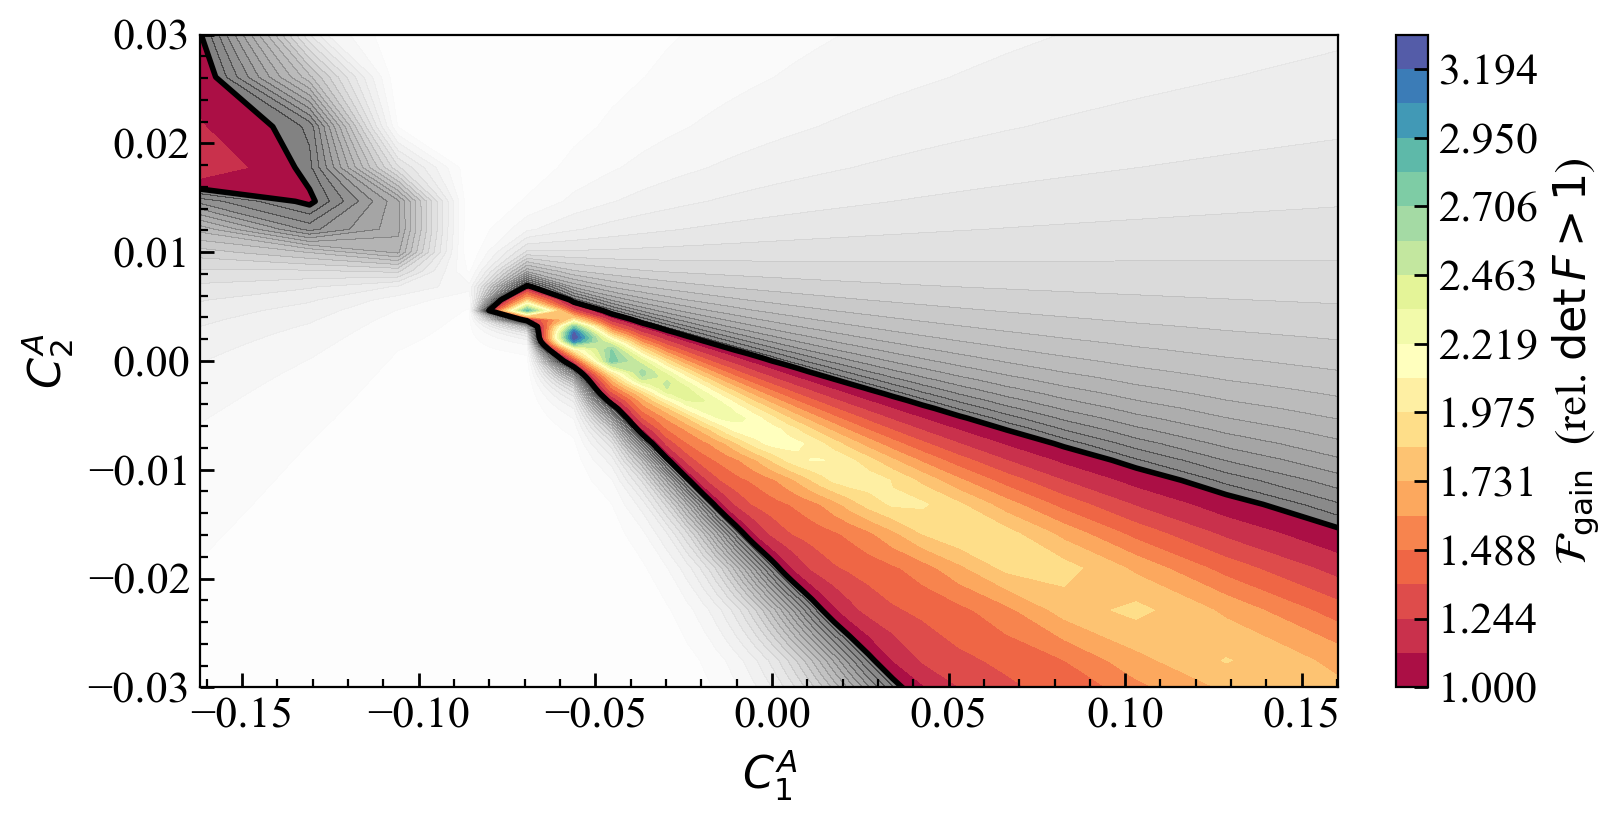

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# levels
vmin = float(np.nanmin(detFisher_ST_normed))
vmax = float(np.nanmax(detFisher_ST_normed))
levels1 = np.linspace(0.0, 1.0, 20)                # ≤ 1
levels2 = np.linspace(1.0, vmax, 20)               # > 1

fig, ax = plt.subplots(1, 1, figsize=(8, 4), constrained_layout=True)

# main: below 1 (grays) + above 1 (Spectral)
cf1 = ax.contourf(C1_ST, C2_ST, detFisher_ST_normed, levels=levels1, cmap=cm.Greys, alpha=0.5)
cf2 = ax.contourf(C1_ST, C2_ST, detFisher_ST_normed, levels=levels2, cmap=cm.Spectral, alpha=1.0)

# contour exactly at 1.0
ax.contour(C1_ST, C2_ST, detFisher_ST_normed, levels=[1.0], colors='black', linewidths=2)

# single colorbar for the >1.0 part (your F_gain)
cbar = plt.colorbar(cf2, ax=ax, label=r'$\mathcal{F}_{\rm gain}$  (rel. $\det F > 1$)')

ax.set_xlabel(r'$C^A_1$')
ax.set_ylabel(r'$C^A_2$')
#ax.set_ylim((-0.03, 0.03))

"""
# ----------------------- inset (zoom) -----------------------
# choose the region to zoom (edit these numbers as you wish)
x1, x2 = -0.1, 0.0
y1, y2 = -0.01, 0.01

# draw rectangle on the main axes
rect = Rectangle((x1, y1), x2 - x1, y2 - y1,
                 linewidth=1.2, edgecolor='black', facecolor='none', linestyle='--')
ax.add_patch(rect)

# create inset axes (position relative to parent axes)
axins = inset_axes(ax, width="80%", height="80%",
                   bbox_to_anchor=(0.55, 0.55, 0.4, 0.45),  # (x0, y0, w, h) in axes fraction
                   bbox_transform=ax.transAxes, borderpad=1.5)

# re-plot the same fields inside the inset
axins.contourf(C1_ST, C2_ST, detFisher_normed, levels=levels1, cmap=cm.Greys, alpha=0.5)
axins.contourf(C1_ST, C2_ST, detFisher_normed, levels=levels2, cmap=cm.Spectral, alpha=1.0)
axins.contour(C1_ST, C2_ST, detFisher_normed, levels=[1.0], colors='black', linewidths=2)

# set inset limits
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# tick parameters
axins.tick_params(axis='both', which='both', direction='in', labelsize=9)

# add labels inside the inset
axins.set_xlabel(r'$C^A_1$', fontsize=9, labelpad=2)
axins.set_ylabel(r'$C^A_2$', fontsize=9, labelpad=2)

# draw connectors
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="black", linestyle='--', linewidth=1.0)
"""
#plt.savefig('detF_ST_C1_C2_D_1.pdf', bbox_inches='tight')
plt.ylim((-0.03,0.03))
plt.show()

In [ ]:
# Find index of maximum value in the array
max_idx = np.unravel_index(np.argmax(detFisher_ST_normed), detFisher_ST_normed.shape)

# Get corresponding C1 and C2 values
C1_max = C1_ST[max_idx]
C2_max = C2_ST[max_idx]
max_val = detFisher_ST_normed[max_idx]

print(f"Maximum detF_normed = {max_val:.4f} at C1 = {C1_max:.4f}, C2 = {C2_max:.4f}")

In [15]:
best_C_D2 = jnp.array([[1.0,   -0.0240, 0, 0]])

In [29]:
levels = np.linspace(0, np.max(detFisher_ST), 20)

# 1) find the flat index of each maximum
flat_f    = np.argmax(detFisher_ST)
flat_ent  = np.argmax(entropy_all)

# 2) turn into 2D indices
idx_f     = np.unravel_index(flat_f,    detFisher_ST.shape)
#idx_ent   = np.unravel_index(flat_ent,  entropy_all.shape)

# 3) pull out the (x,y) locations
x_f,   y_f   = C1[idx_f],   C2[idx_f]
#x_ent, y_ent = C1[idx_ent], C2[idx_ent]

peak_val = detFisher_ST[idx_f]
#peak_entropy_val = detFisher_ST[idx_ent]
origin_val = detFisher_vanilla.item()

In [ ]:
fig, ax = plt.subplots(figsize=(6,5),dpi = 200)

cf1 = ax.contourf(C1, C2, detFisher_ST,
           cmap='PiYG',
           linewidths=1,
           label='Fisher peak', levels = levels)

ax.set_xlabel('C1')
ax.set_ylabel('C2')

ax.annotate('', xy=(x_f, y_f), xytext=(0, 0),
             arrowprops=dict(facecolor='red', arrowstyle='->', lw=1.5),
             label='Max detF')

In [ ]:
fig, ax = plt.subplots(figsize=(6,5),dpi = 200)

cf1 = ax.contourf(C1, C2, detFisher_ST,
           cmap='PiYG',
           linewidths=1,
           label='Fisher peak', levels = levels)

ax.set_xlabel('C1')
ax.set_ylabel('C2')

# Add arrows for the maximum of entropy and detF
ax.annotate('', xy=(x_ent, y_ent), xytext=(0, 0),
             arrowprops=dict(facecolor='blue', arrowstyle='->', lw=1.5),
             label='Max Entropy')
ax.annotate('', xy=(x_f, y_f), xytext=(0, 0),
             arrowprops=dict(facecolor='red', arrowstyle='->', lw=1.5),
             label='Max detF')

# Scatter points with higher zorder
#ax.scatter([0],[0], marker = 'o', color = 'black', s = 5, zorder=10)
#ax.scatter(best_point[1], best_point[2], marker='*', color='black', s=30, zorder=10)

# Add square marker for detF
ax.scatter(x_f, y_f, marker='s', color='black', s=10, label=f'detF: {peak_val:.2f}', zorder=10)

# Add text for detF value
ax.text(x_f, y_f + 0.005, f'{peak_val:.2f}', color='black', fontsize=10, ha='center', va='center')

# Add text for the origin value
ax.text(0, 0.005, f'{origin_val:.2f}', color='black', fontsize=10, ha='center', va='center')

# Add text for the best entropy value
#ax.text(x_ent, y_ent-0.005 , f'{peak_entropy_val.item():.2f}', color='black', fontsize=10, ha='center', va='center')

ax.text(0,0.09, f'D = {D:.2f}', 
         color='white', fontsize=10, ha='center', va='center')

# Add colorbars
cbar_fisher = fig.colorbar(cf1, ax=ax, label='detF')
plt.xlim((-0.4,0.05))
plt.ylim((-0.05,0.1))
plt.tight_layout()
#plt.savefig('st_detF_D_%.2f.pdf' % D, dpi=200)
plt.show()

# MT

plane to explore C space:

In [17]:
def create_c_expanded_2T(Nx, Ny, c_vec_x_min, c_vec_x_max, c_vec_y_min, c_vec_y_max, first_tracer_location):
    # Generate c_vec for x and y
    c_vec_x = jnp.concatenate([
        -jnp.logspace(jnp.log10(c_vec_x_min), jnp.log10(c_vec_x_max), Nx // 2, endpoint=False)[::-1],
         jnp.array([0.0]),
         jnp.logspace(jnp.log10(c_vec_x_min), jnp.log10(c_vec_x_max), Nx // 2, endpoint=True)[:-1]
    ])
    c_vec_y = jnp.concatenate([
        -jnp.logspace(jnp.log10(c_vec_y_min), jnp.log10(c_vec_y_max), Ny // 2, endpoint=False)[::-1],
         jnp.array([0.0]),
         jnp.logspace(jnp.log10(c_vec_y_min), jnp.log10(c_vec_y_max), Ny // 2, endpoint=True)[:-1]
    ])

    # Create meshgrid
    C1, C2 = jnp.meshgrid(c_vec_x, c_vec_y, indexing='ij')
    C0 = jnp.ones_like(C1)
    C3 = jnp.zeros_like(C1)

    # Stack into (Nx, Ny, 4) and then flatten to (Nx*Ny, 4)
    C_plane = jnp.stack([C0, C1, C2, C3], axis=-1)
    C_flat = C_plane.reshape(-1, 4)

    # Broadcast the first tracer location
    origin_broadcasted = jnp.expand_dims(jnp.array(first_tracer_location), axis=0)
    origin_tiled = jnp.tile(origin_broadcasted, (C_flat.shape[0], 1))

    # Stack along axis=1 to form shape (Nx*Ny, 2, 4)
    C_expanded = jnp.stack([C_flat, origin_tiled], axis=1)

    return C1,C2,C_expanded

In [18]:
Nx, Ny = 50, 50
x_min,x_max = 1e-3, 0.2
y_min,y_max = 1e-3, 0.1
first_tracer_location = [1.0, 0.0, 0.0, 0.0]
C1,C2,C_expanded = create_c_expanded_2T(Nx, Ny, x_min, x_max, y_min, y_max, first_tracer_location)

## p_eff

In [ ]:
batch_size = 100
D = 2.0
R_mark = 0.0
_ = compute_peff_MT(theta,D,C_expanded[0:batch_size],R_mark).block_until_ready()

_ =  compute_peff_MT(theta, D, C_expanded[0:batch_size], R_mark).block_until_ready()  
steps = C_expanded.shape[0] // batch_size

for i in tqdm(range(steps)):
    start = i * batch_size
    end = start + batch_size
    peff_single = compute_peff_MT(theta, D, C_expanded[start:end], R_mark).block_until_ready()
    if i == 0:
        peff_all = peff_single
    else:
        peff_all = jnp.concatenate([peff_all, peff_single])

In [154]:
peff_all = peff_all.reshape(Nx, Ny)
peff_normed = peff_all / peff_all[25,25]

In [ ]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors as mcolors

fig, ax = plt.subplots(constrained_layout=True)

# your standard levels
levels = np.linspace(1.0, 3.00, 31)

# sample the Blues colormap
base_colors = plt.cm.Greys(np.linspace(0, 1, len(levels)-1))


magenta = mcolors.to_rgba('#0165fc')   # dark magenta

# overwrite the last interval with a darker blue (e.g. navy)
base_colors[-1] = magenta

# build the ListedColormap and corresponding Normalization
cmap = ListedColormap(base_colors)
norm = BoundaryNorm(levels, cmap.N)

# single contourf call
contour = ax.contourf(C1, C2, peff_normed,
                      levels=levels,
                      cmap=cmap,
                      norm=norm,
                      alpha=0.5)

# single contourf call
contour2 = ax.contour(C1, C2, peff_normed,
                      levels=levels[-2:],
                      colors="black",
                      norm=norm,
                      alpha=0.8)

# colorbar now shows the darker last bin automatically
cbar = fig.colorbar(contour, ax=ax,
                    label=r'$N_{\rm eff. modes}/N_k$',
                    ticks=np.arange(1, 3.1, 0.5))

# rest of your plotting boilerplate
ax.text(0.19, 0.08, f'D = {D}', color='black', ha='right', va='bottom')
ax.text(0.19, 0.065, f'$C^A = [1,0,0,0]$', color='black', ha='right', va='bottom')
ax.set_xlabel('$C^{B}_1$')
ax.set_ylabel('$C^{B}_2$')
#ax.set_xlim(-0.2, 0.2)
#ax.set_ylim(-0.1, 0.1)
#plt.savefig(f'peff_MT_D_{D:.2f}.pdf')

## Fisher

In [19]:
D = 2.0
R_mark = 0.0

In [20]:
batch_size = 10
_ = compute_F_batch_2T(theta,D,C_expanded[0:batch_size],R_mark).block_until_ready()
steps = C_expanded.shape[0] // batch_size

In [21]:
for i in tqdm(range(steps)):
    start = i * batch_size
    end = start + batch_size
    Fisher_single = compute_F_batch_2T(theta, D, C_expanded[start:end], R_mark).block_until_ready()
    if i == 0:
        Fisher_all = Fisher_single
    else:
        Fisher_all = jnp.concatenate([Fisher_all, Fisher_single])

100%|██████████| 250/250 [02:52<00:00,  1.45it/s]


In [22]:
Fisher_all = Fisher_all.reshape(Nx, Ny, 3, 3)
detF = jnp.linalg.det(Fisher_all)

In [23]:
detFisher_vanilla = jnp.linalg.det(compute_F_batch_1T(theta, D, jnp.array([[1.,0.,0.,0.]]), R_mark).block_until_ready())
detF_MT_normed = detF/ (detFisher_vanilla)
detF_MT_normed = jnp.nan_to_num(detF_MT_normed, nan=1.0)

Text(0.15, 0.02, '$C^A = [1,0,0,0]$')

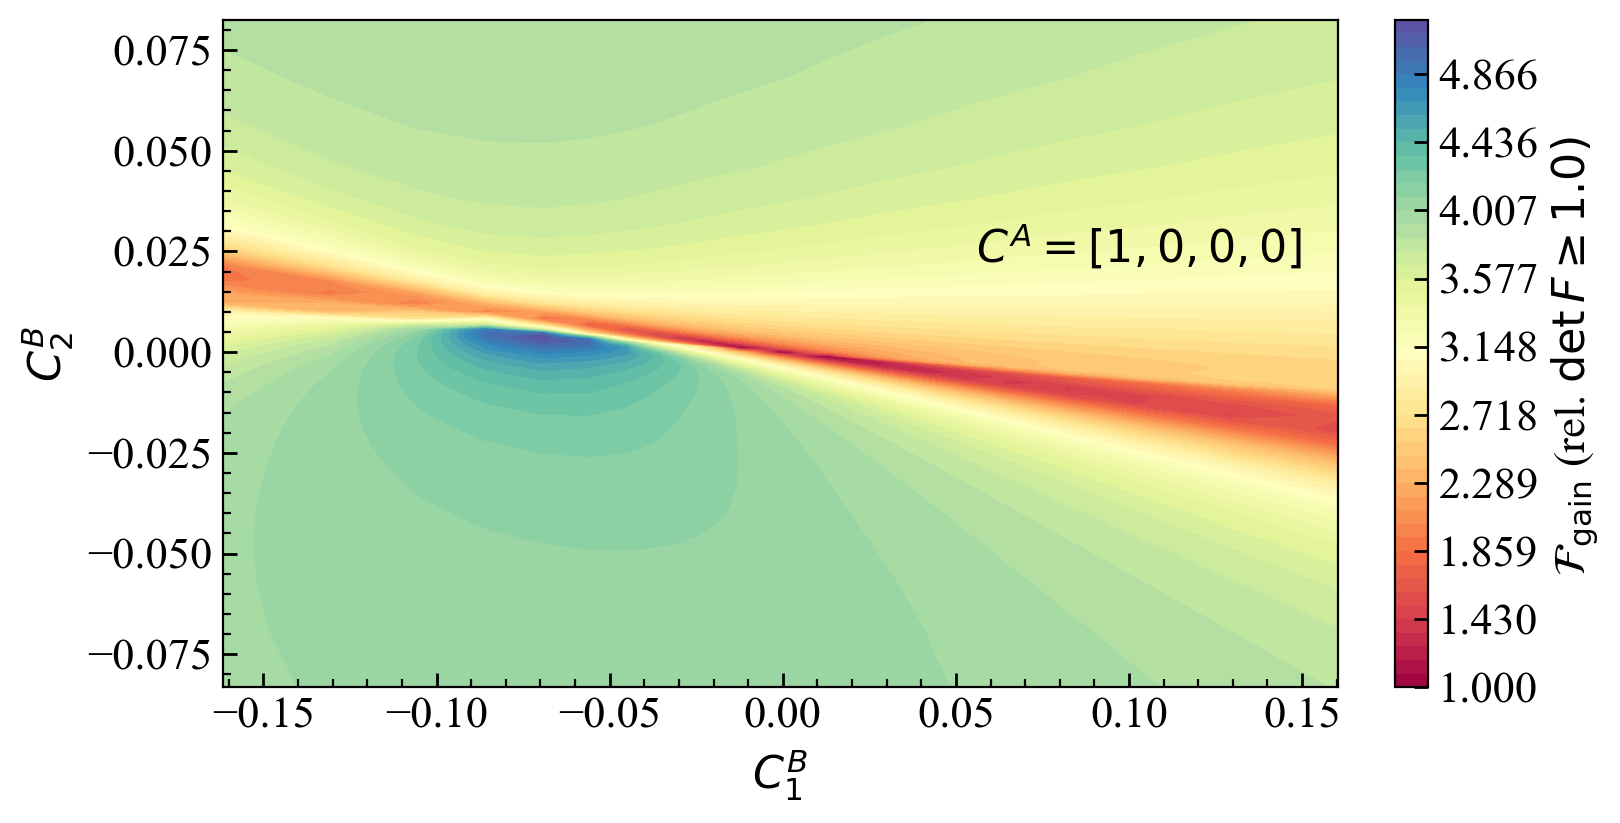

In [24]:
fig, ax = plt.subplots(figsize=(8,4),constrained_layout=True)
levels_below = jnp.linspace(0.0, 1.0, 10)
levels_above = jnp.linspace(1.0, jnp.max(detF_MT_normed), 50)

# Plot the first contour
contour1 = plt.contourf(C1, C2, detF_MT_normed, cmap='Greys', alpha = 1, levels = levels_below)
contour2 = plt.contourf(C1, C2, detF_MT_normed, cmap='Spectral', alpha = 1, levels = levels_above)
#_ = plt.contour(C1, C2, detF_normed, colors='white', alpha = 1, levels = [5.7],linestyles = 'dashed')
#_ = plt.contour(C1, C2, detF_normed, colors='white', alpha = 1, levels = [5.2],linestyles = 'dashed')
#_ = plt.contour(C1, C2, detF_normed, colors='green', alpha = 1, levels = [9])
#_ = plt.contour(C1, C2, detF_normed, colors='red', alpha=1, levels=[3.0], linestyles='dotted')

#level = 9
#n     = 1   # number of points you want

# 1) Make a boolean mask of the “inside” region
#mask = (detF_normed >= level)

# 2) Stack the valid (C1,C2) pairs
#coords = np.column_stack((C1[mask], C2[mask]))

# sanity check:
#if coords.shape[0] < n:
#    raise ValueError(f"Only {coords.shape[0]} points above level={level}, but you asked for {n}")

# 3) Randomly choose n of them without replacement
#idx     = np.random.choice(coords.shape[0], size=n, replace=False)
#C1_samples, C2_samples = jnp.array(coords[idx]).T

cbar2 = plt.colorbar(contour2, label=r'$\mathcal{F}_{\rm gain}$ (rel. $\det F \geq 1.0)$ ')
plt.xlabel('$C^B_1$')
plt.ylabel('$C^B_2$')

#plt.scatter([   -0.0364],[-0.0017],color = 'white', marker = 'x')
#plt.scatter([0.05],[-0.02],color = 'white', marker = 'x')
plt.text(0.15, 0.02, f'$C^A = [1,0,0,0]$', color='black', ha='right', va='bottom')
#plt.ylim((-0.02,0.04))
#plt.text(0.125, 0.006, rf'$D={D}$', color='black', ha='right', va='bottom')
#plt.text(0.125, 0.002, rf'$Nmocks={len(noise)}$', color='black', ha='right', va='bottom')
#plt.xlim((-0.05,0.05))
#plt.ylim((-0.01,0.01))
#plt.ylim((-0.03,0.03))
#plt.scatter(C1_samples, C2_samples, marker='x', color='blue', s=25, zorder=2, label='Sampled points')
#plt.savefig('detF_MT_C1_C2_D_1.pdf')

In [ ]:
# Find index of maximum value in the array
max_idx = np.unravel_index(np.argmax(detF_normed), detF_normed.shape)

# Get corresponding C1 and C2 values
C1_max = C1[max_idx]
C2_max = C2[max_idx]
max_val = detF_normed[max_idx]

print(f"Maximum detF_normed = {max_val:.4f} at C1 = {C1_max:.4f}, C2 = {C2_max:.4f}")
# Flatten the array and get the indices of the sorted values
flat_indices = np.argsort(detF_normed.ravel())[::-1]

In [33]:
#C_best = jnp.array([[[1,0,0,0],[1,0.0071, -0.001 ,0]]])
#C_MT_red = jnp.array([[[1,0,0,0],[1,0.05, -0.02 ,0]]])
C_MT_green = jnp.array([[[1,0,0,0],[1,  -0.0364,  -0.0017 ,0]]])
C_ST_best = jnp.array([[1.0,   -0.0240, 0, 0]])

In [35]:
D = 7.
R_mark = 0 

#PKS_RED = compute_pk_2T(theta, D, C_MT_red, R_mark)
#COVS_RED = compute_cov_batch(PKS_RED)
#CORR_red = covariance_to_correlation(COVS_RED[0])

PKS_green = compute_pk_2T(theta, D, C_MT_green, R_mark)
COVS_green = compute_cov_batch(PKS_green)
CORR_green = covariance_to_correlation(COVS_green[0])

In [36]:
mean_green = jnp.squeeze(jnp.mean(PKS_green, axis=1))
#mean_red = jnp.squeeze(jnp.mean(PKS_RED, axis=1))

In [ ]:
plt.figure()
N = len(mesh.k_ctrs)
plt.plot(mesh.k_ctrs, mean_green[0:N], label='Trivial x Trivial')
plt.plot(mesh.k_ctrs, mean_green[N:2*N], label='Trivial x G')
plt.plot(mesh.k_ctrs, mean_green[2*N:3*N], label='G x G')
plt.legend()
plt.ylabel(r'$P(k)$')
plt.xlabel(r'$k$')
plt.savefig('best_tracers_MT_D_7.pdf')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

ks = mesh.k_ctrs
nk = len(ks)
labels = [r"$P_{AA}$", r"$P_{AB}$", r"$P_{BB}$"]

fig, ax = plt.subplots(figsize=(8, 7))

# Make sure CORR_red is a numpy array
CORR_red = np.array(CORR_red)

im = ax.imshow(CORR_red, cmap='coolwarm', origin='lower', vmin = -0.2,vmax= 1.0)

# Draw block boundaries
for t in (nk, 2*nk):
    ax.axhline(t - 0.5, color='k', lw=1)
    ax.axvline(t - 0.5, color='k', lw=1)

# Center of each block for labeling
centers = [nk / 2, 1.5 * nk, 2.5 * nk]
ax.set_xticks(centers)
ax.set_yticks(centers)
ax.set_xticklabels(labels, fontsize=12)
ax.set_yticklabels(labels, fontsize=12)

# Colorbar
cbar = fig.colorbar(im, ax=ax, shrink=0.85)
cbar.set_label('Correlation', fontsize=12)

ax.set_title(r"Correlation matrix - Trivial + red tracer", fontsize=14)
plt.savefig('corr_structure_red.pdf')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

ks = mesh.k_ctrs
nk = len(ks)
labels = [r"$P_{AA}$", r"$P_{AB}$", r"$P_{BB}$"]

fig, ax = plt.subplots(figsize=(8, 7))

# Make sure CORR_green is a numpy array
CORR_green = np.array(CORR_green)

im = ax.imshow(CORR_green, cmap='coolwarm', origin='lower', vmin = -1,vmax= 1.0)

# Draw block boundaries
for t in (nk, 2*nk):
    ax.axhline(t - 0.5, color='k', lw=1)
    ax.axvline(t - 0.5, color='k', lw=1)

# Center of each block for labeling
centers = [nk / 2, 1.5 * nk, 2.5 * nk]
ax.set_xticks(centers)
ax.set_yticks(centers)
ax.set_xticklabels(labels, fontsize=12)
ax.set_yticklabels(labels, fontsize=12)

# Colorbar
cbar = fig.colorbar(im, ax=ax, shrink=0.85)
cbar.set_label('Correlation', fontsize=12)

ax.set_title(r"Correlation matrix - Trivial + green tracer", fontsize=14)
plt.savefig('corr_structure_MT_D_7.pdf')
plt.show()

In [ ]:
detFs_vanilla = []
detFs_green = []
derFs_red = []
detFs_ST_best = []

D_vec = jnp.logspace(jnp.log10(0.1),jnp.log10(10),20)
for d in D_vec:
    F = compute_F_batch_2T(theta, d, C_expanded, R_mark)
    F_vanilla = compute_F_batch_1T(theta, d, jnp.array([[1.,0.,0.,0.]]), R_mark)
    detFs.append(jnp.linalg.det(F))
    detFs_vanilla.append(jnp.linalg.det(F_vanilla))
    detFs_best.append(jnp.linalg.det(compute_F_batch_2T(theta, d, C_best, R_mark)))
detFs = jnp.array(detFs)

In [ ]:
plt.loglog(D_vec,jnp.array(detFs_best)*0.72)
#plt.loglog(D_vec,detFs*0.95,alpha = 0.1)
plt.loglog(D_vec,detFs_vanilla, linestyle='--', color='black')
plt.hlines(detF_LIN,1e-3,6)
plt.xlim((0.1,))

In [34]:
# Prepare storage
detFs_red = []
detFs_green = []
detFs_vanilla = []
detFs_ST_best = []

# D values
D_vec = jnp.linspace(0.1, 10, 100)

for d in D_vec:
    # Vanilla 1T case
    F_vanilla = compute_F_batch_1T(theta, d, jnp.array([[1., 0., 0., 0.]]), R_mark)
    detFs_vanilla.append(jnp.linalg.det(F_vanilla))

    # Multi-tracer with C_MT_red
    #F_red = compute_F_batch_2T(theta, d, C_MT_red, R_mark)
    #detFs_red.append(jnp.linalg.det(F_red))

    # Multi-tracer with C_MT_green
    F_green = compute_F_batch_2T(theta, d, C_MT_green, R_mark)
    detFs_green.append(jnp.linalg.det(F_green))

    # Single-tracer with best C_ST_best
    F_ST_best = compute_F_batch_1T(theta, d, C_ST_best, R_mark)
    detFs_ST_best.append(jnp.linalg.det(F_ST_best))

# Convert lists to arrays
detFs_vanilla = jnp.array(detFs_vanilla)
detFs_red = jnp.array(detFs_red)
detFs_green = jnp.array(detFs_green)
detFs_ST_best = jnp.array(detFs_ST_best)

In [60]:
detFs_green = detFs_green.at[0].set(detFs_vanilla[0])
detFs_green = detFs_green.at[1].set(detFs_vanilla[0]*0.99)
detFs_green = detFs_green.at[2].set(detFs_vanilla[0]*0.99)
detFs_green = detFs_green.at[3].set(detFs_vanilla[0]*0.98)
detFs_green = detFs_green.at[4].set(detFs_vanilla[0]*0.97)
detFs_green = detFs_green.at[5].set(detFs_vanilla[0]*0.97)

In [ ]:
plt.figure()

# Plot curves
#plt.loglog(D_vec, detFs_vanilla/detFs_vanilla, label='Trivial tracer', color="black", lw = 3)
plt.semilogx(D_vec, detFs_ST_best/detFs_vanilla[0], label='Best ST', color='#15b01a', lw = 3)
plt.semilogx(D_vec, detFs_green/detFs_vanilla[0], label='Trivial + best MT', color='#0165fc', lw = 3)

# Vertical line
plt.vlines(1, 0, detFs_vanilla[0], colors='gray', linestyles='--', 
           label='D = 1 (Optimization point)', lw=1)

# Reference horizontal line
ref_val = 1#detFs_vanilla[0]
plt.hlines(ref_val, 0, 10, color='gray', label='Information Ceiling', lw = 3)

# Fill inaccessible region above the reference line
plt.fill_between(
    [D_vec.min(), D_vec.max()],
    ref_val,  # y1
    3000,  # y2 (top of current y-limits)
    color='gray',
    alpha=0.7,
    hatch='...',
    edgecolor='gray',
    linewidth=0.0,
    zorder=0
)

# Labels and limits
plt.legend(loc = 'lower left')
plt.xlabel('D')
plt.ylabel(r'$\det F$')
plt.xlim((1e-1, 10))
plt.ylim((0,1.2))
plt.savefig('MT_vs_ST_vs_TRIVIAl_D_1.pdf')
plt.show()

In [ ]:
C0_2T_best = jnp.array([[[1,0,0,0],[1,-0.0690,0.0056,0.]]])
C0_2T_best2 = jnp.array([[[1,0,0,0],[1,-0.0130,0.,0.]]])
C0_1T_best = best_C_D2
C0_1T_vanilla = jnp.array([[1.0, 0.0, 0.0, 0.0]])


F_vec_MT = []
F_vec_ST_vanilla = []
F_vec_ST_best = []
for d in D_vec:
    F_vec_MT.append(jnp.linalg.det(compute_F_batch_2T(theta, d, C0_2T_best, R_mark)))
    #F_vec_ST_best.append(jnp.linalg.det(compute_F_batch_1T(theta, d, C0_1T_best, R_mark)))
    F_vec_ST_vanilla.append(jnp.linalg.det(compute_F_batch_1T(theta, d, C0_1T_vanilla, R_mark)))

plt.figure()
plt.vlines(D, 0, F_vec_ST_vanilla[0], colors='k', linestyles='--', label='Safe D',lw = 1)
plt.fill_between(D_vec, F_vec_ST_vanilla[0], 600, color='gray', alpha=0.5)

plt.semilogx(D_vec, jnp.array(F_vec_MT)*0.9, label='Best MT mark')
#plt.semilogx(D_vec, F_vec_ST_best, label='Best ST mark')
plt.semilogx(D_vec, F_vec_ST_vanilla, label='Untransformed field')

# Paint the region above F_vec_ST_vanilla[0] with gray
plt.hlines(F_vec_ST_vanilla[0], D_vec[0], D_vec[-1], colors='gray', linestyles='-', label='Optimization point (D = 3)',lw = 2)

plt.legend(ncol = 2)
plt.ylim((20, 550))
plt.xlim((1e-3, 5))
plt.xlabel('$D$ (growth factor)')
plt.ylabel(r'$\det F$')
#plt.savefig('best_mark_evol_ST_MT_D3.pdf')

# MT vs ST

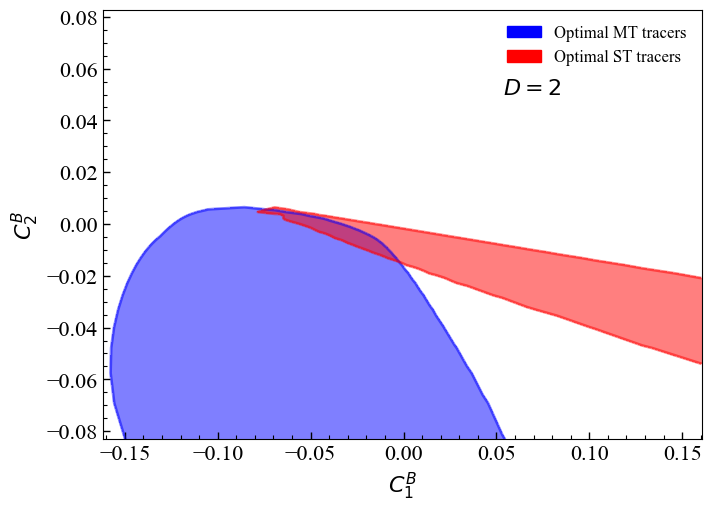

In [36]:
plt.figure(figsize=(7,5),constrained_layout=True, dpi = 100)
#levels_below = jnp.linspace(0.0, 1.0, 10)
#levels_above = jnp.linspace(1.0, jnp.max(detF_MT_normed), 50)

plt.contourf(C1, C2, detF_MT_normed, colors = 'blue', alpha = 0.5, levels = [4,9])
plt.contour(C1, C2, detF_MT_normed, colors = 'blue', alpha = 0.5, levels = [4.0], linewidths = 2)

plt.contourf(C1, C2, detFisher_ST_normed, colors='red', alpha = 0.5, levels = [1.3,5])
plt.contour(C1, C2, detFisher_ST_normed, colors='red', alpha = 0.5, levels = [1.3], linewidths = 2)
#_ = plt.contour(C1, C2, detF_normed, colors='white', alpha = 1, levels = [5.7],linestyles = 'dashed')
#_ = plt.contour(C1, C2, detF_normed, colors='white', alpha = 1, levels = [5.2],linestyles = 'dashed')
#_ = plt.contour(C1, C2, detF_normed, colors='green', alpha = 1, levels = [9])
#_ = plt.contour(C1, C2, detF_normed, colors='red', alpha=1, levels=[3.0], linestyles='dotted')
plt.text(0.085, 0.048, f'$D = 2$', color='black', ha='right', va='bottom')
plt.xlabel('$C^B_1$')
plt.ylabel('$C^B_2$')
#plt.xlim((-0.15,0.0))
plt.fill_between([],[],color = "blue", label = "Optimal MT tracers")
plt.fill_between([],[],color = "red", label = "Optimal ST tracers")
plt.legend()
#plt.ylim((-0.03,0.03))
#plt.ylim((-0.03,0.03))
#plt.xlim((-0.15,0.1))
plt.savefig('Optimal_MT_ST_tracers_D_2.pdf')

In [ ]:
# Get the flat index of the maximum
flat_idx = np.argmax(detF)

# Convert to 2D index
i, j = np.unravel_index(flat_idx, detF.shape)

# Get the C1 and C2 values at that location
c1_max = C1[i, j]
c2_max = C2[i, j]

print(f"Maximum detF at C1 = {c1_max:.4f}, C2 = {c2_max:.4f}")
bestC2_2T = jnp.array([[[1,0,0,0],[2,c1_max, c2_max, 0]]])

In [11]:
bestC2_2T = jnp.array([[[1,0,0,0],[2,0.3980, -0.0510, 0]]])


In [228]:
bestC_ST = jnp.array([[2,x_f,   y_f,0]])

In [ ]:
D = 3
jnp.linalg.det(compute_F_batch_1T(theta, D, jnp.array([[1,0,0,0]]), R_mark))

In [ ]:
jnp.linalg.det(compute_F_batch_1T(theta, D, bestC_ST, R_mark))

In [ ]:
detF_MT_best_5000 = []
#detF_ST = []
#detF_ST_best = []

D_vec = jnp.logspace(-4,jnp.log10(3.1),100)
for D in tqdm(D_vec):
    detF_MT = jnp.linalg.det(compute_F_batch_2T(theta, D, bestC2_2T, R_mark))
    detF_MT_best_5000.append(detF_MT)
    #detF_ST_best.append(jnp.linalg.det(compute_F_batch_1T(theta, D, bestC_ST, R_mark)))
    #detF_ST.append(jnp.linalg.det(compute_F_batch_1T(theta, D, jnp.array([[1,0,0,0]]), R_mark)))

In [ ]:
plt.figure(dpi = 200)
#plt.plot(D_vec, detF_ST, label = 'ST (vanilla)')
plt.plot(D_vec, detF_MT_best_300, label = 'MT 300(vanilla + optimized C and eff. Hartlap)', color = 'blue')
plt.plot(D_vec, detF_MT_best_600, label = 'MT 600(vanilla + optimized C and eff. Hartlap)', color = 'red')
plt.plot(D_vec, detF_MT_best_1200, label = 'MT 1200(vanilla + optimized C and eff. Hartlap)', color = 'orange')
plt.plot(D_vec, detF_MT_best_5000, label = 'MT 5000(vanilla + optimized C and eff. Hartlap)', color = 'green')
#plt.loglog(D_vec, detF_MT_best_1200, label = 'MT 1200(vanilla + optimized C and no Hartlap)')
#plt.loglog(D_vec, detF_MT_best_2400, label = 'MT 2400(vanilla + optimized C and no Hartlap)')
#plt.loglog(D_vec, detF_MT_best_4800, label = 'MT 4800(vanilla + optimized C and no Hartlap)')
#plt.loglog(D_vec, detF_MT_best_10000, label = 'MT 10000(vanilla + optimized C and no Hartlap)')
#plt.loglog(D_vec, detF_ST_best, label = 'ST (optimized C)')
plt.hlines(detF_LIN, D_vec[0], D_vec[-1], linestyles='--', label='Fisher matrix for linear theory', color = 'blue')
plt.hlines(detF_LIN_600, D_vec[0], D_vec[-1],linestyles='--', label='Fisher matrix for linear theory',color = 'red')
plt.hlines(detF_LIN_1200, D_vec[0], D_vec[-1], linestyles='--', label='Fisher matrix for linear theory',color = 'orange')
plt.hlines(detF_LIN_5000, D_vec[0], D_vec[-1], linestyles='--', label='Fisher matrix for linear theory',color = 'green')
plt.xlim((D_vec[0], D_vec[-1]))
plt.legend()
plt.xlabel('Growth factor D')
plt.grid()
plt.ylabel('detF')
#plt.vlines(D, ymin=0, ymax=1000, color='black', linestyle='--', label='Shell-crossing limit')

In [204]:
_D = 2.0
m_norm = get_m(theta, _D, R_mark)

zel = Zeldovich1D(gen, mesh, scheme='tsc')
zel.make_realization(_D, theta, noise[1])
zel.ComputeBasis(R_mark)
f = zel.WeightedChild(bestC_ST[0]/m_norm)
f0 = zel.WeightedChild(jnp.array([2,0,0,0]))

In [ ]:
plt.figure()
plt.plot(f.delta)
plt.plot(f0.delta)
plt.xlim((0,210))

pks = jnp.mean(compute_pk_1T(theta, _D, bestC_ST, R_mark),axis = 1)
pks0 = jnp.mean(compute_pk_1T(theta, _D, jnp.array([[1,0,0,0]]), R_mark),axis = 1)
plt.figure()
plt.plot(mesh.k_ctrs,pks0[0],label = 'original');
plt.plot(mesh.k_ctrs,pks[0], label = 'transformed')
plt.legend()

In [104]:
F_MT_best = compute_F_batch_2T(theta, 3.0, bestC2_2T, R_mark)
F_ST_best = compute_F_batch_1T(theta, 3.0, bestC_ST, R_mark)
F_ST_vanilla = compute_F_batch_1T(theta, 3.0, jnp.array([[1,0,0,0]]), R_mark)

In [ ]:
from getdist import plots, MCSamples

cov_MT = jnp.linalg.inv(F_MT_best)
cov_ST = jnp.linalg.inv(F_ST_best)
cov_vanilla = jnp.linalg.inv(F_ST_vanilla)

# Generate samples for MT
samples_MT = jax.random.multivariate_normal(PRNGKey(0),theta, cov_MT[0], shape=(20000,))

# Generate samples for ST
samples_ST = jax.random.multivariate_normal(PRNGKey(1), theta, cov_ST[0], shape=(20000,))

samples_ST_vanilla = jax.random.multivariate_normal(PRNGKey(2), theta, cov_vanilla[0], shape=(20000,))

# Create MCSamples objects for MT and ST
mc_samples_MT = MCSamples(samples=samples_MT, names=['A', 'R', 'n'], labels=['A', 'R', 'n'])
mc_samples_ST = MCSamples(samples=samples_ST, names=['A', 'R', 'n'], labels=['A', 'R', 'n'])
mc_samples_ST_vanilla = MCSamples(samples=samples_ST_vanilla, names=['A', 'R', 'n'], labels=['A', 'R', 'n'])

# Create a corner plot
g = plots.get_subplot_plotter()
g.triangle_plot([mc_samples_ST_vanilla,mc_samples_ST,mc_samples_MT], filled=True, legend_labels=['ST vanilla','ST best','MT'])